<a href="https://colab.research.google.com/github/Shiv2612/Neural-Network-SMS-Text-Classifier/blob/main/Neural_Network_SMS_Text_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Neural Network SMS Text Classifier***

**Instruction**

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called predict_message that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the SMS Spam Collection dataset. The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.

**Load Libraries**

In [1]:
!wget -N https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget -N https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
# !pip install tensorflow-datasets

--2023-11-05 03:52:40--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.005s  

2023-11-05 03:52:40 (63.5 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2023-11-05 03:52:41--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==========

**Import libraries**

In [4]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
# import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from keras.layers.experimental.preprocessing import TextVectorization
from keras import layers
from keras.preprocessing import sequence
#tfds.disable_progress_bar()

**Prepare data**

In [5]:
train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

train_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [6]:
test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [7]:
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]

In [8]:
train_df.head()

,type,msg
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?


In [9]:
train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["msg"].values, train_labels)
)

In [10]:
test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["msg"].values, test_labels)
)
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [11]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
vec = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

vec.adapt(train_ds.map(lambda text, label: text))

In [13]:
vocab = np.array(vec.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'is', 'in',
       'me', 'my', 'your', 'for', 'have', 'it', 'of', 'call', 'that'],
      dtype='<U16')

In [14]:
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

In [15]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
44/44 [==============================] - 169s 3s/step - loss: 0.6793 - accuracy: 0.8657 - val_loss: 0.6571 - val_accuracy: 0.8604
Epoch 2/10
44/44 [==============================] - 176s 4s/step - loss: 0.6118 - accuracy: 0.8657 - val_loss: 0.5501 - val_accuracy: 0.8604
Epoch 3/10
44/44 [==============================] - 152s 3s/step - loss: 0.5034 - accuracy: 0.8657 - val_loss: 0.4754 - val_accuracy: 0.8604
Epoch 4/10
44/44 [==============================] - 143s 3s/step - loss: 0.4375 - accuracy: 0.8657 - val_loss: 0.3993 - val_accuracy: 0.8604
Epoch 5/10
44/44 [==============================] - 137s 3s/step - loss: 0.3409 - accuracy: 0.8657 - val_loss: 0.2678 - val_accuracy: 0.8604
Epoch 6/10
44/44 [==============================] - 143s 3s/step - loss: 0.2017 - accuracy: 0.8836 - val_loss: 0.1451 - val_accuracy: 0.9438
Epoch 7/10
44/44 [==============================] - 142s 3s/step - loss: 0.1206 - accuracy: 0.9648 - val_loss: 0.0930 - val_accuracy: 0.9771
Epoch 8/10
44

In [16]:
test_loss, test_acc = model.evaluate(test_ds)

44/44 [==============================] - 24s 551ms/step - loss: 0.0422 - accuracy: 0.9899


In [17]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.04224041476845741
Test Accuracy: 0.9899425506591797


**Plot the accuracy and loss metrics**

In [18]:
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 0.7109424944967031)

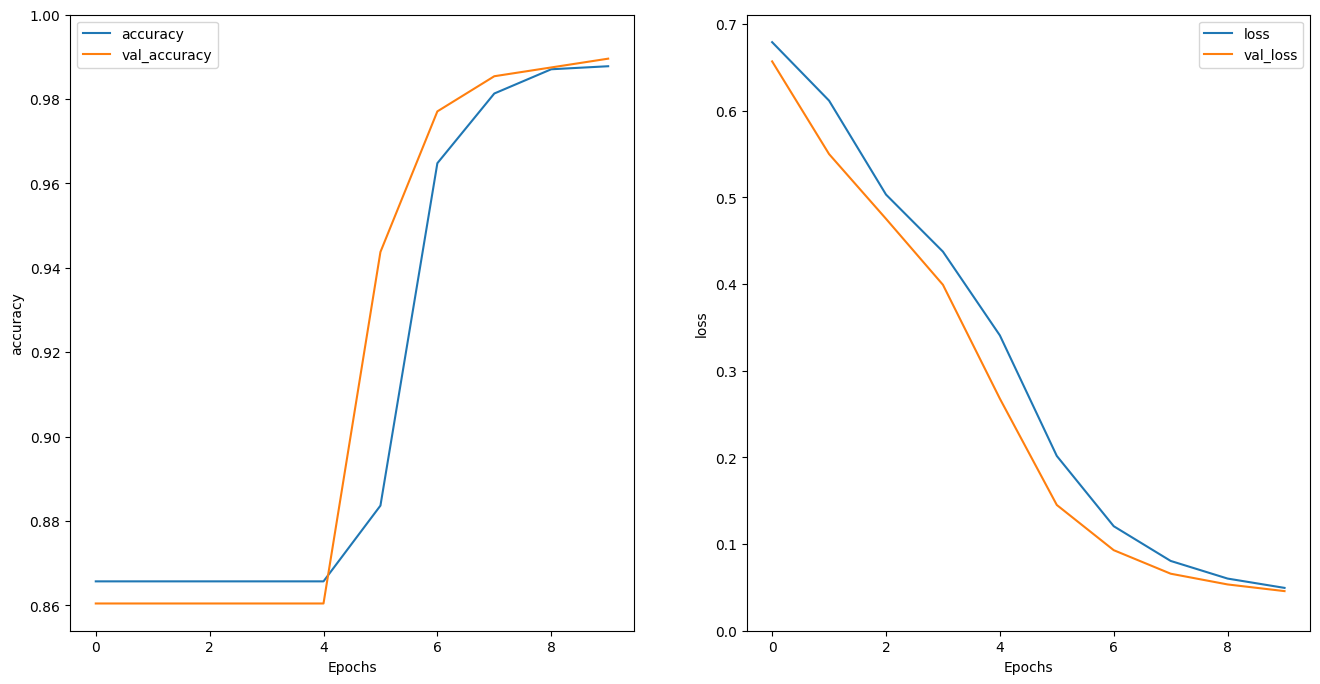

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [20]:
h = history.history
print(h['loss'])
print(h['val_loss'])
print(h['accuracy'])
print(h['val_accuracy'])

[0.6792646050453186, 0.6117856502532959, 0.5033886432647705, 0.43751442432403564, 0.3408519923686981, 0.20171532034873962, 0.12060584127902985, 0.08054562658071518, 0.06018275395035744, 0.04943631589412689]
[0.6570771336555481, 0.5501120090484619, 0.47540128231048584, 0.39926499128341675, 0.2678409218788147, 0.1451309621334076, 0.09295783191919327, 0.06581217050552368, 0.053412698209285736, 0.045706816017627716]
[0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8836206793785095, 0.9647988677024841, 0.9813218116760254, 0.9870689511299133, 0.9877873659133911]
[0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.9437500238418579, 0.9770833253860474, 0.9854166507720947, 0.987500011920929, 0.9895833134651184]


In [21]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    ps = model.predict([pred_text])
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 6s 6s/step
[[-4.8096957]]
[-4.8096957, 'ham']


**Test**

In [22]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460 4",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

1/1 [==============================] - 0s 216ms/step
[[-4.8096957]]
1/1 [==============================] - 0s 236ms/step
[[0.61722726]]
1/1 [==============================] - 0s 212ms/step
[[-10.185925]]
1/1 [==============================] - 0s 214ms/step
[[1.9218348]]
1/1 [==============================] - 0s 214ms/step
[[2.2652886]]
1/1 [==============================] - 0s 235ms/step
[[-8.668868]]
1/1 [==============================] - 0s 221ms/step
[[-8.603935]]
You passed the challenge. Great job!
